In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from string import ascii_letters
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
import cddm_data_simulation as cds
import boundary_functions as bf
# Set styles
sns.set(style = "white")

In [26]:
# BG Data Weibull
bg_data = pickle.load(open('/media/data_cifs/afengler/data/real/bg_stn_sampling_ready.pickle', 'rb'))

fold = '/media/data_cifs/afengler/data/kde/weibull_cdf/method_comparison/'
files_ = os.listdir(fold)
data_weibull = []
for file_ in files_:
    if "_expanded_bounds__" in file_:
        #print(file_)
        data_weibull.append(pickle.load(open(fold + file_, 'rb'))[2])
        
data_weibull_full = np.zeros((6, 25, 10000, 6))
for i in range(data_weibull_full.shape[1]):
    data_weibull_full[:, i, :, :] = data_weibull[i]
means_weibull = np.mean(data_weibull_full[:, :, 5000:, :], axis = 2)
data_weibull = data_weibull_full[:, :, 5000:, :]

# BG Data Angle
fold = '/media/data_cifs/afengler/data/kde/angle/method_comparison/'
files_ = os.listdir(fold)
data_angle = []
for file_ in files_:
    if "_expanded_bounds__" in file_:
        #print(file_)
        data_angle.append(pickle.load(open(fold + file_, 'rb'))[2])
        
data_angle_full = np.zeros((6, 25, 10000, 5))
for i in range(data_angle_full.shape[1]):
    data_angle_full[:, i, :, :] = data_angle[i]
means_angle = np.mean(data_angle_full[:, :, 5000:, :], axis = 2)
data_angle = data_angle_full[:, :, 5000:, :]


fold = '/media/data_cifs/afengler/data/kde/ornstein/method_comparison/'
files_ = os.listdir(fold)
data_ornstein = []
for file_ in files_:
    if "_expanded_bounds__" in file_:
        data_ornstein.append(pickle.load(open(fold + file_, 'rb'))[2])
        
data_ornstein_full = np.zeros((6, 25, 10000, 5))
for i in range(data_ornstein_full.shape[1]):
    data_ornstein_full[:, i, :, :] = data_ornstein[i]
means_ornstein = np.mean(data_ornstein_full[:, :, 5000:, :], axis = 2)
data_ornstein = data_ornstein_full[:, :, 5000:, :]

In [55]:
def bgn_mean_predictive_plot(ax_titles = ['hiconf_go_stnhi.txt',
                                          'hiconf_go_stnlo.txt',
                                          'hiconf_go_stnmid.txt',
                                          'loconf7_go_stnhi.txt',
                                          'loconf7_go_stnlo.txt',
                                          'loconf7_go_stnmid.txt'], 
                             title = 'BG-STN: POSTERIOR MEAN PREDICTIVE',
                             x_labels = [],
                             mean_posterior_parameters = [],
                             data = [],
                             model = 'angle',
                             figure_name = 'bg_stn_mean_posterior_',
                             cols = 3,
                             show = False):
    
    rows = int(np.ceil(len(ax_titles) / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True,
            font_scale = 2)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title, fontsize = 40)

    sns.despine(right = True)

    for i in range(data.shape[0]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        # Run Model simulations
        if model == 'angle':
            out = cds.ddm_flexbound(v = mean_posterior_parameters[i][0],
                                    a = mean_posterior_parameters[i][1],
                                    w = mean_posterior_parameters[i][2],
                                    ndt = mean_posterior_parameters[i][3],
                                    s = 1,
                                    delta_t = 0.01, 
                                    max_t = 20,
                                    n_samples = 20000,
                                    print_info = False,
                                    boundary_fun = bf.angle,
                                    boundary_multiplicative = False,
                                    boundary_params = {'theta': mean_posterior_parameters[i][4]})
        if model == 'weibull_cdf':
            out = cds.ddm_flexbound(v = mean_posterior_parameters[i][0],
                                    a = mean_posterior_parameters[i][1],
                                    w = mean_posterior_parameters[i][2],
                                    ndt = mean_posterior_parameters[i][3],
                                    s = 1,
                                    delta_t = 0.01, 
                                    max_t = 20,
                                    n_samples = 20000,
                                    print_info = False,
                                    boundary_fun = bf.weibull_cdf,
                                    boundary_multiplicative = True,
                                    boundary_params = {'alpha': mean_posterior_parameters[i][4],
                                                       'beta': mean_posterior_parameters[i][5]})
        if model == 'ornstein_uhlen':
                print('passed')
                out = cds.ornstein_uhlenbeck(v = mean_posterior_parameters[i][0],
                                             a = mean_posterior_parameters[i][1],
                                             w = mean_posterior_parameters[i][2],
                                             g = mean_posterior_parameters[i][3],
                                             ndt = mean_posterior_parameters[i][4],
                                             s = 1,
                                             delta_t = 0.001, 
                                             n_samples = 20000,
                                             print_info = False,
                                             boundary_fun = bf.constant,
                                             boundary_multiplicative = True,
                                             boundary_params = {})
            
        
        sns.distplot(out[0] * out[1], bins = 50, 
                     kde = False, 
                     rug = False, 
                     hist_kws = {'alpha': 0.2, 'color': 'blue', 'density': 1},
                     ax = ax[row_tmp, col_tmp]);
        sns.distplot(bg_data[0][0][:, 0] * bg_data[0][0][:, 1], 
                     hist_kws = {'alpha': 0.2, 'color': 'green', 'density': 1}, 
                     bins = 50, 
                     kde = False, 
                     rug = False,
                     ax = ax[row_tmp, col_tmp])
        
        ax[row_tmp, col_tmp].legend(labels = [model, 'bg-stn'], fontsize = 20)
        ax[row_tmp, col_tmp].set_xlabel('rt', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_ylabel('density', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_title(ax_titles[i],
                                       fontsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = 'y', size = 24)
        ax[row_tmp, col_tmp].tick_params(axis = 'x', size = 24)
        
    for i in range(data.shape[0], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    #plt.setp(ax, yticks = [])
    plt.savefig(os.getcwd() + '/figures/' + figure_name + model, dpi = 150)
    
    if show:
        return plt.show()

In [86]:
# Mean posterior predictives
def bgn_posterior_predictive_plot(ax_titles = ['hiconf_go_stnhi.txt',
                                               'hiconf_go_stnlo.txt',
                                               'hiconf_go_stnmid.txt',
                                               'loconf7_go_stnhi.txt',
                                               'loconf7_go_stnlo.txt',
                                               'loconf7_go_stnmid.txt'], 
                                 title = 'BG-STN: POSTERIOR PREDICTIVE',
                                 x_labels = [],
                                 posterior_parameters = [],
                                 data = [],
                                 cols = 3,
                                 model = 'angle',
                                 figure_name = 'bg_posterior_predictive',
                                 n_post_params = 200,
                                 samples_by_param = 10,
                                 show = False):
    
    rows = int(np.ceil(len(ax_titles) / cols))
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True,
            font_scale = 2)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title, fontsize = 40)
    sns.despine(right = True)

    for i in range(data.shape[0]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        tmp = np.zeros((n_post_params*samples_by_param, 2))
        idx = np.random.choice(posterior_parameters.shape[1], size = n_post_params, replace = False)

        # Run Model simulations
        for j in range(n_post_params):
            if model == 'angle':
                #print('passed angle')
                out = cds.ddm_flexbound(v = posterior_parameters[i, idx[j], 0],
                                        a = posterior_parameters[i, idx[j], 1],
                                        w = posterior_parameters[i, idx[j], 2],
                                        ndt = posterior_parameters[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.01, 
                                        max_t = 20,
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.angle,
                                        boundary_multiplicative = False,
                                        boundary_params = {'theta': posterior_parameters[i, idx[j], 4]})
            
            if model == 'weibull_cdf':
                #print('passed_weibu')
                out = cds.ddm_flexbound(v = posterior_parameters[i, idx[j], 0],
                                    a = posterior_parameters[i, idx[j], 1],
                                    w = posterior_parameters[i, idx[j], 2],
                                    ndt = posterior_parameters[i, idx[j], 3],
                                    s = 1,
                                    delta_t = 0.01, 
                                    max_t = 20,
                                    n_samples = samples_by_param,
                                    print_info = False,
                                    boundary_fun = bf.weibull_cdf,
                                    boundary_multiplicative = True,
                                    boundary_params = {'alpha': posterior_parameters[i, idx[j], 4],
                                                       'beta': posterior_parameters[i, idx[j], 5]})
                
            if model == 'ornstein':
                #print('passed')
                out = cds.ornstein_uhlenbeck(v = posterior_parameters[i, idx[j], 0],
                                             a = posterior_parameters[i, idx[j], 1],
                                             w = posterior_parameters[i, idx[j], 2],
                                             g = posterior_parameters[i, idx[j], 3],
                                             ndt = posterior_parameters[i, idx[j], 4],
                                             s = 1,
                                             delta_t = 0.001, 
                                             n_samples = samples_by_param,
                                             print_info = False,
                                             boundary_fun = bf.constant,
                                             boundary_multiplicative = True,
                                             boundary_params = {})
            
            tmp[(10 * j):(10 * (j + 1)), :] = np.concatenate([out[0], out[1]], axis = 1)
        
        print('passed through')
            
        sns.distplot(tmp[:, 0] * tmp[:, 1], 
                     bins = 50, 
                     kde = False, 
                     rug = False, 
                     hist_kws = {'alpha': 0.2, 'color': 'blue', 'density': 1},
                     ax = ax[row_tmp, col_tmp]);
        sns.distplot(data[i, :, 0] * data[i, :, 1], 
                     hist_kws = {'alpha': 0.2, 'color': 'green', 'density': 1}, 
                     bins = 50, 
                     kde = False, 
                     rug = False,
                     ax = ax[row_tmp, col_tmp])
        
        ax[row_tmp, col_tmp].legend(labels = [model, 'bg_stn'], fontsize = 20)
        ax[row_tmp, col_tmp].set_xlabel('rt', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_ylabel('density', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_title(ax_titles[i],
                                       fontsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = 'y', size = 24)
        ax[row_tmp, col_tmp].tick_params(axis = 'x', size = 24)
        
    for i in range(data.shape[0], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    #plt.setp(ax, yticks = [])
    plt.savefig(os.getcwd() + '/figures/' + figure_name + model, dpi = 150)
    
    if show:
        return plt.show()

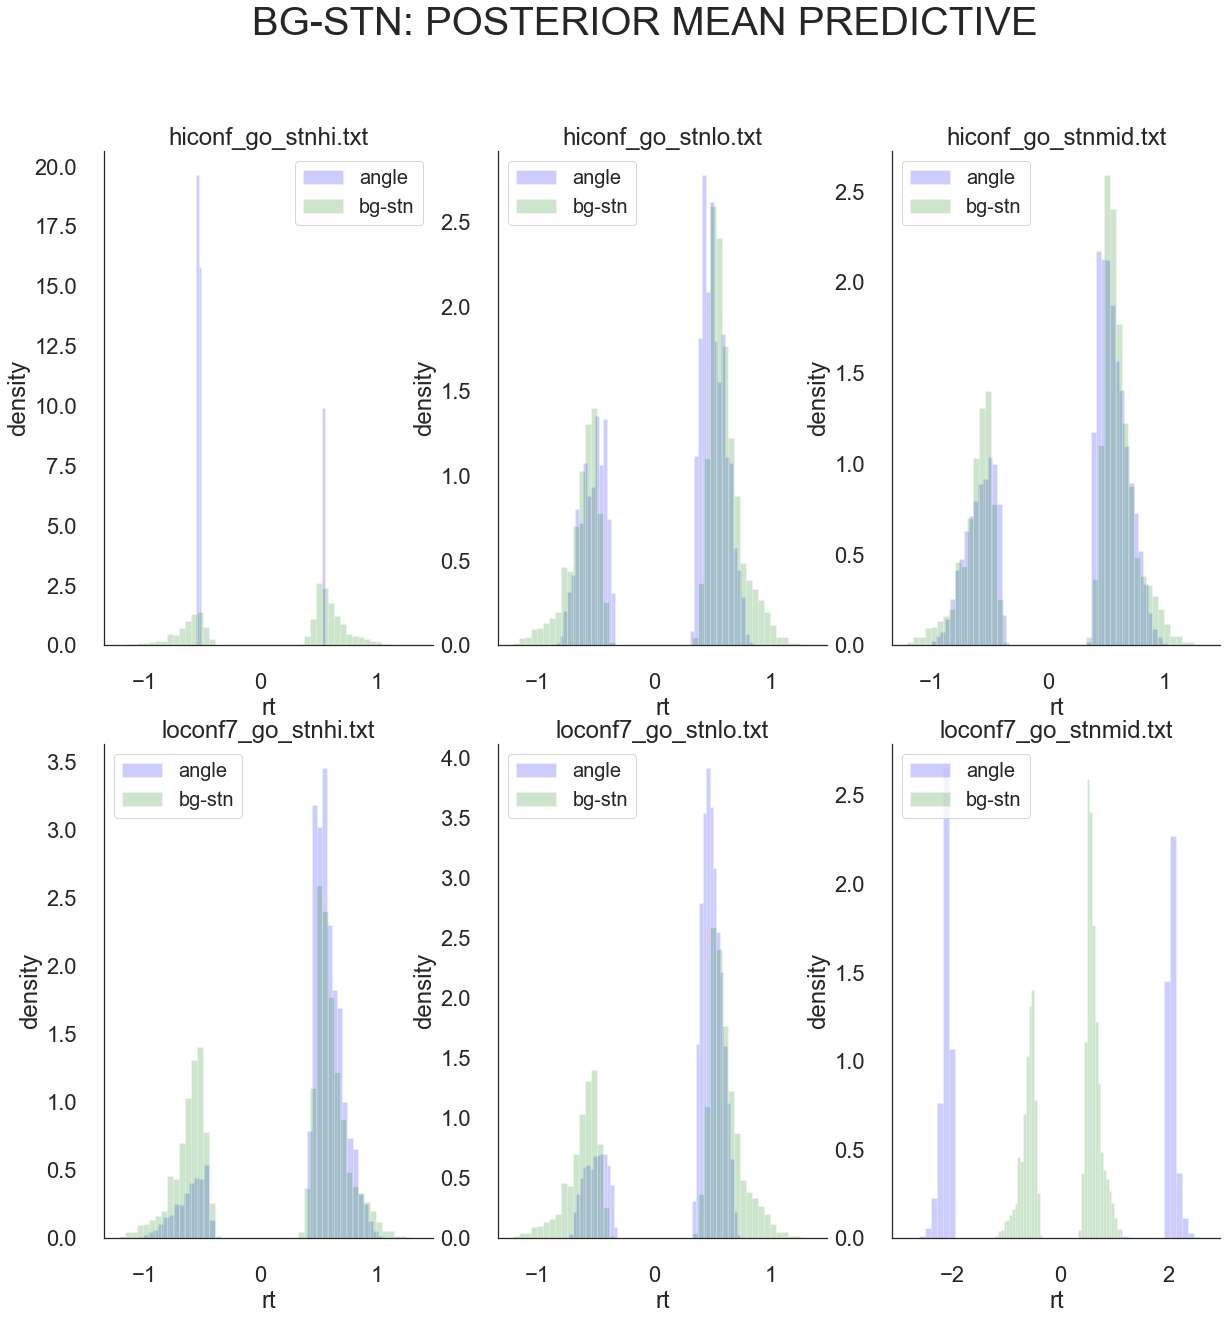

In [94]:
# ANGLE MEAN PREDICTIVE
bgn_mean_predictive_plot(mean_posterior_parameters = means_angle[:, 5, :],
                         data = bg_data[0],
                         model = 'angle')

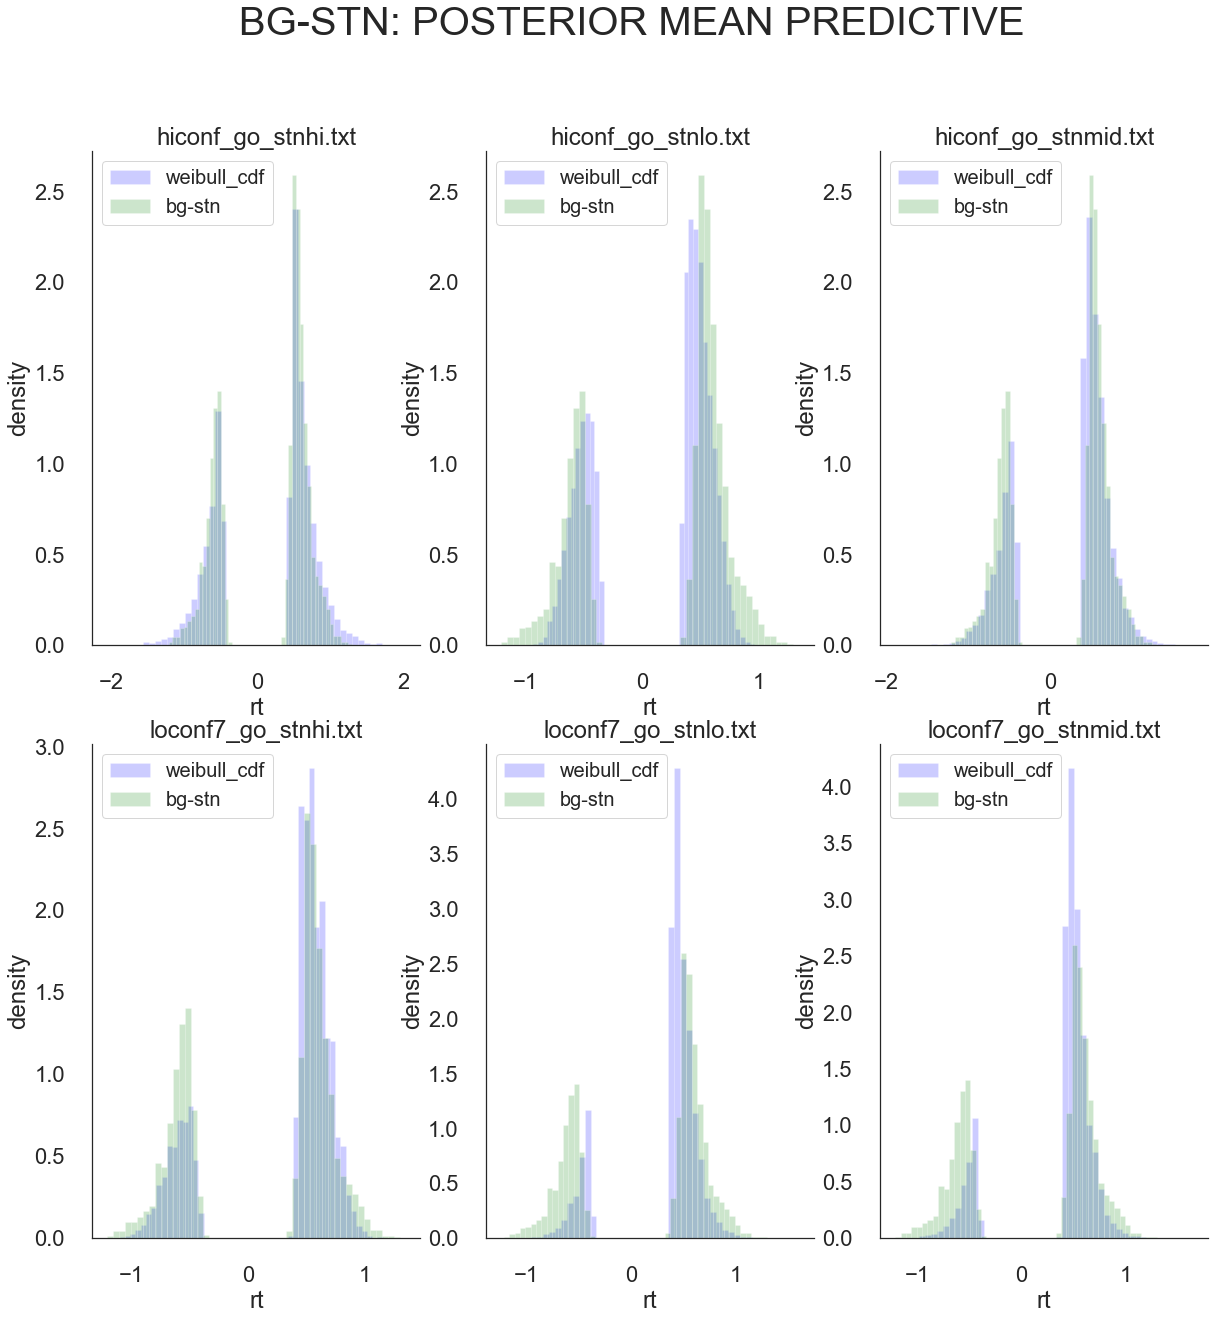

In [74]:
# WEIBULL CDF MEAN PREDICTIVE
bgn_mean_predictive_plot(mean_posterior_parameters = means_weibull[:, 8, :],
                         data = bg_data[0],
                         model = 'weibull_cdf')

passed
passed
passed
passed
passed
passed


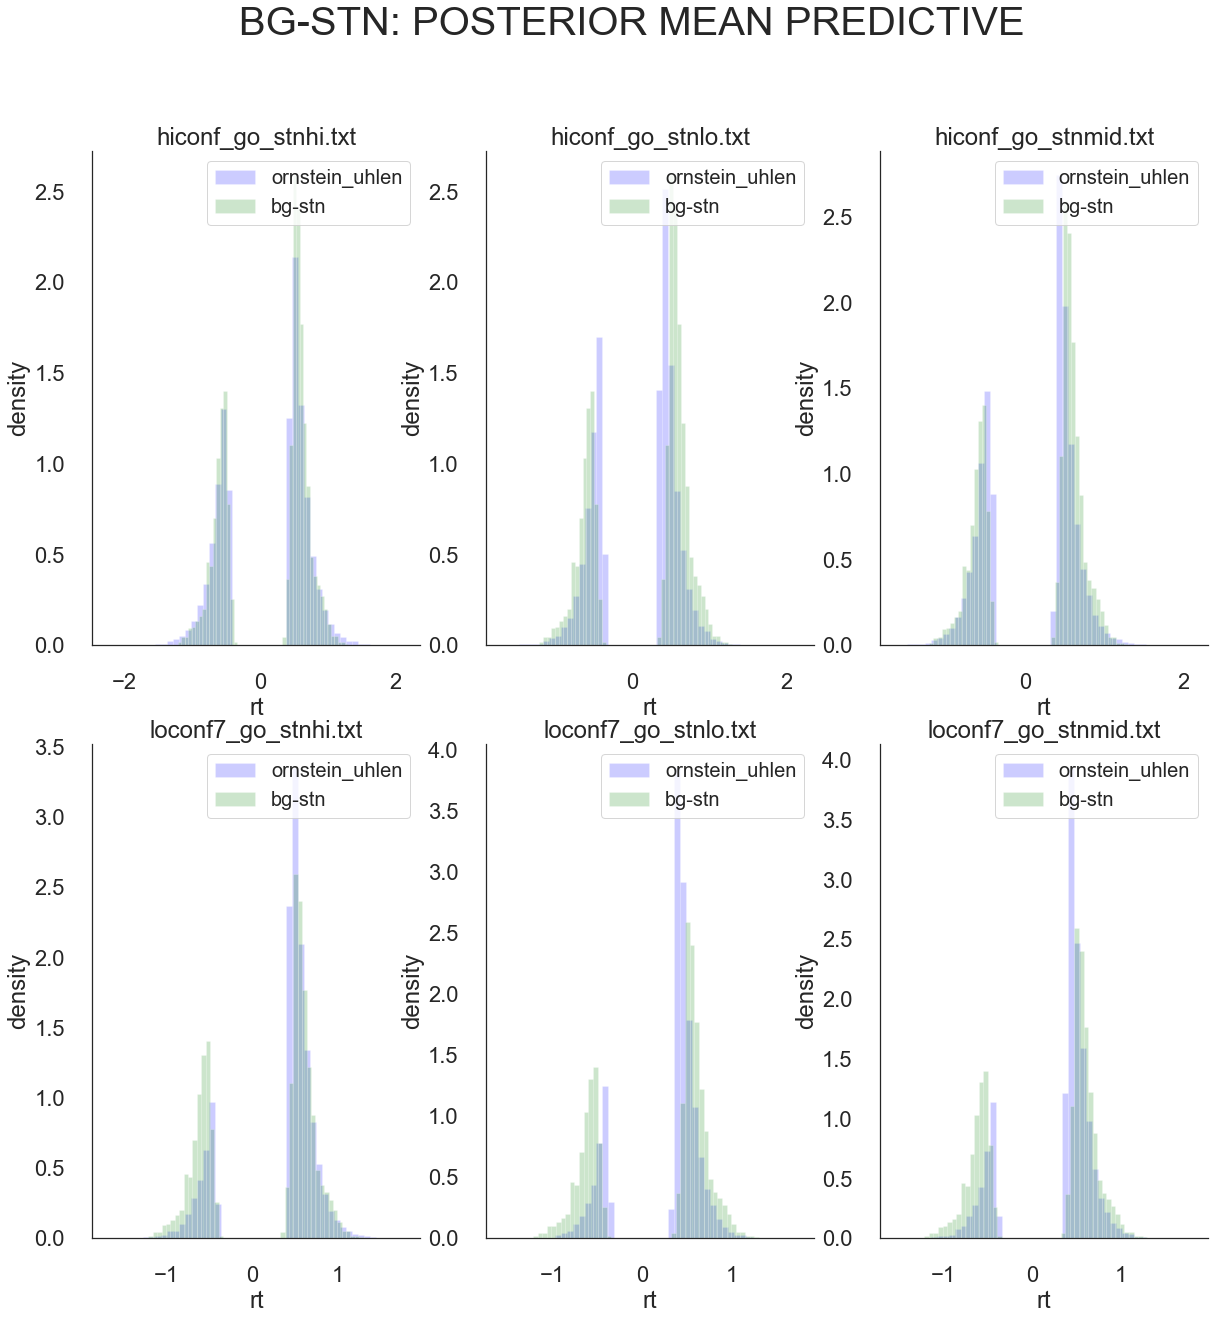

In [69]:
# ORNSTEIN
bgn_mean_predictive_plot(mean_posterior_parameters = means_ornstein[:, 18, :],
                         data = bg_data[0],
                         model = "ornstein_uhlen")

In [32]:
means_ornstein.shape

(6, 25, 5)

passed through
passed through
passed through
passed through
passed through
passed through


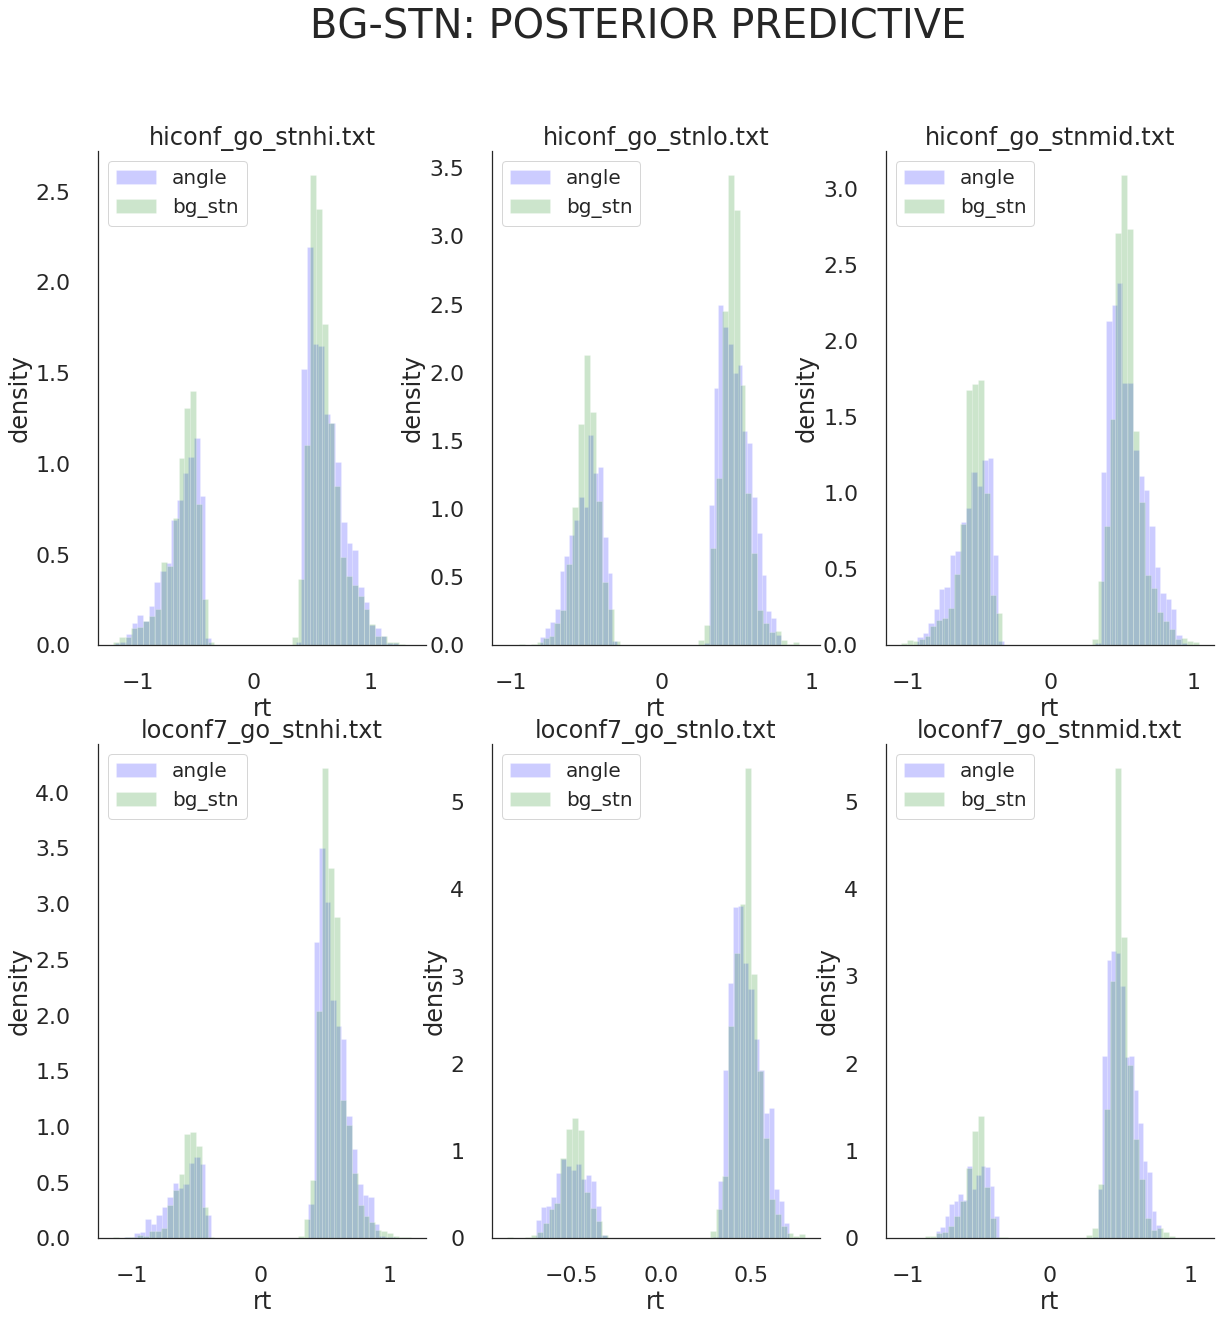

In [17]:
# ANGLE POSTERIOR PREDICTIVE
data_angle_tmp = data_angle[:, 1, :, :]
bgn_posterior_predictive_plot(ax_titles = ['hiconf_go_stnhi.txt',
                                           'hiconf_go_stnlo.txt',
                                           'hiconf_go_stnmid.txt',
                                           'loconf7_go_stnhi.txt',
                                           'loconf7_go_stnlo.txt',
                                           'loconf7_go_stnmid.txt'], 
                                 title = 'BG-STN: POSTERIOR PREDICTIVE',
                                 x_labels = [],
                                 posterior_parameters = data_angle_tmp,
                                 data = bg_data[0],
                                 cols = 3,
                                 n_post_params = 200,
                                 figure_name = 'bg_stn_posterior_predictive_',
                                 model = 'angle')

passed through
passed through
passed through
passed through
passed through
passed through


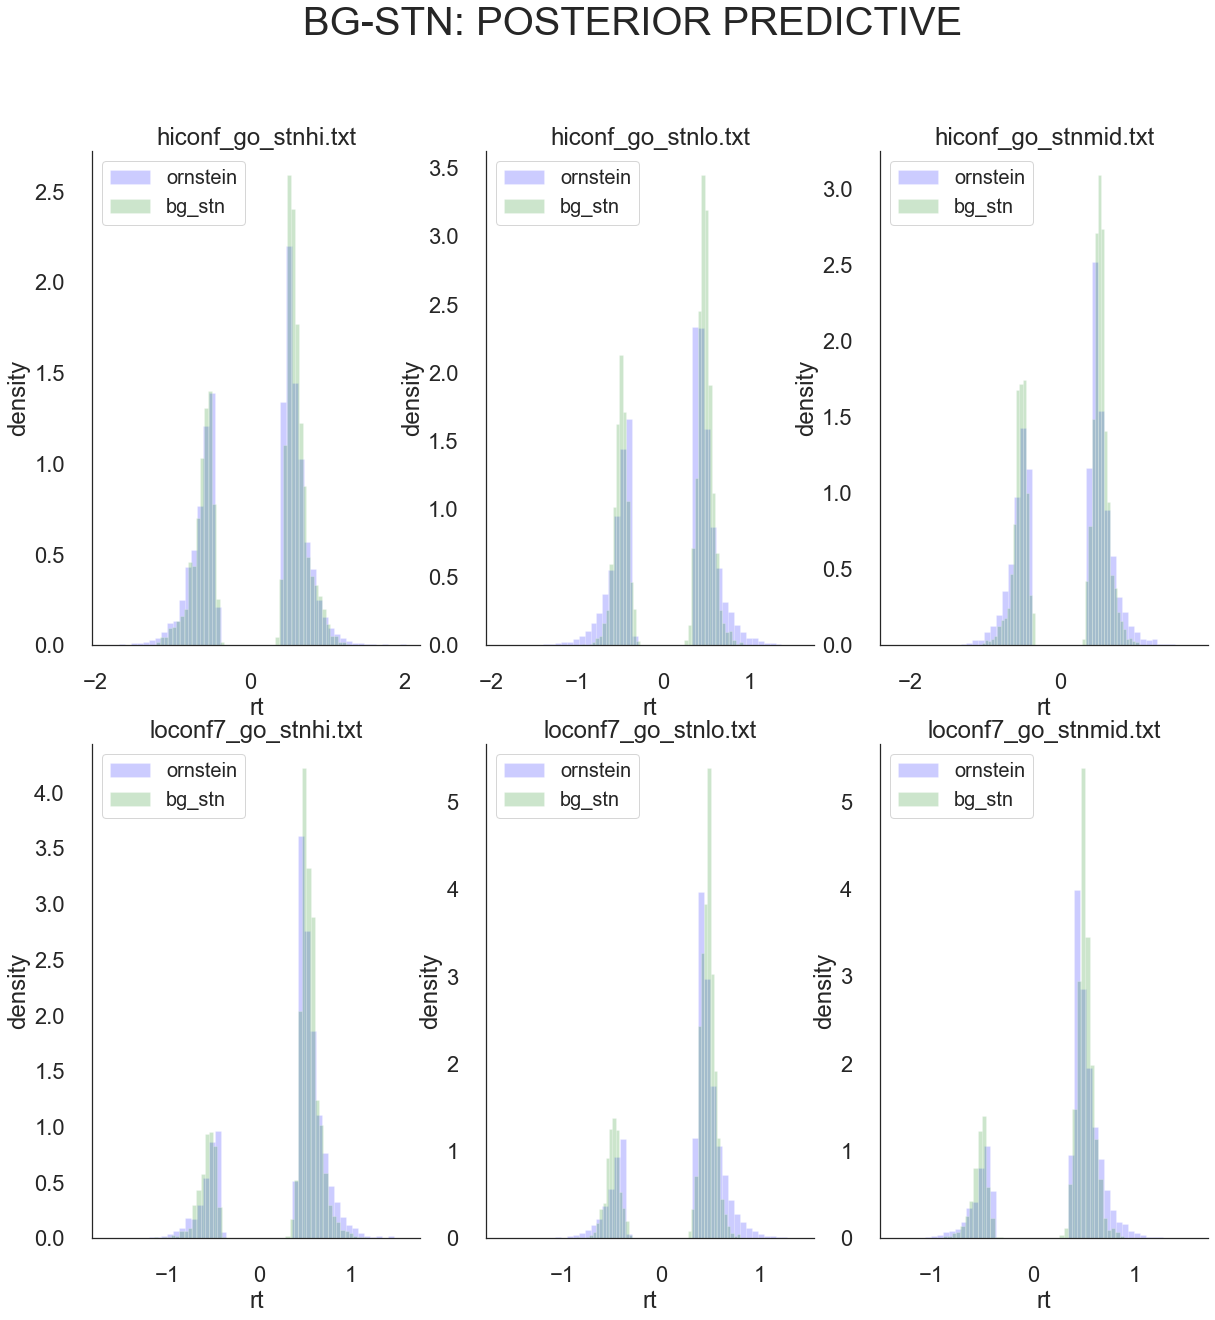

In [88]:
# ORNSTEIN
data_ornstein_tmp = data_ornstein[:, 18, :, :]
bgn_posterior_predictive_plot(ax_titles = ['hiconf_go_stnhi.txt',
                                           'hiconf_go_stnlo.txt',
                                           'hiconf_go_stnmid.txt',
                                           'loconf7_go_stnhi.txt',
                                           'loconf7_go_stnlo.txt',
                                           'loconf7_go_stnmid.txt'], 
                                 title = 'BG-STN: POSTERIOR PREDICTIVE',
                                 x_labels = [],
                                 posterior_parameters = data_ornstein_tmp,
                                 data = bg_data[0],
                                 cols = 3,
                                 n_post_params = 500,
                                 samples_by_param = 10,
                                 figure_name = 'bg_stn_posterior_predictive_',
                                 model = 'ornstein')


# bgn_mean_predictive_plot(mean_posterior_parameters = means_ornstein[:, 18, :],
#                          data = bg_data[0],
#                          model = "ornstein_uhlen")

passed through
passed through
passed through
passed through
passed through
passed through


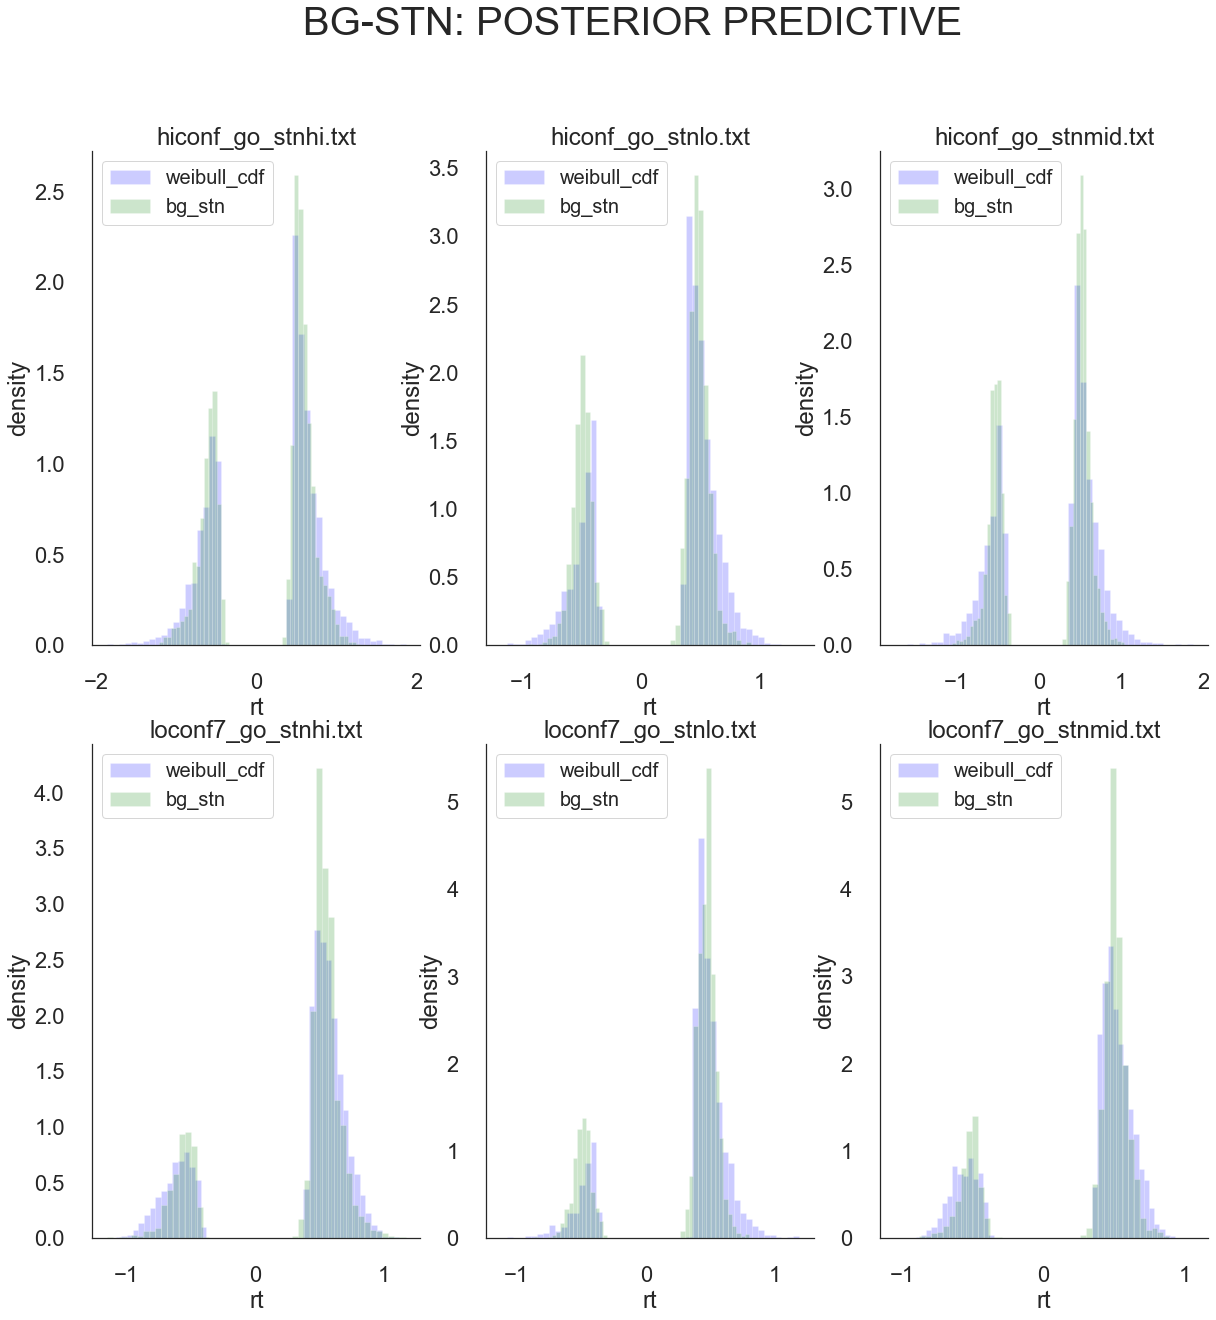

In [81]:
# WEIBULL POSTERIOR PREDICTIVE
data_weibull_tmp = data_weibull[:, 0, :, :]
bgn_posterior_predictive_plot(ax_titles = ['hiconf_go_stnhi.txt',
                                           'hiconf_go_stnlo.txt',
                                           'hiconf_go_stnmid.txt',
                                           'loconf7_go_stnhi.txt',
                                           'loconf7_go_stnlo.txt',
                                           'loconf7_go_stnmid.txt'], 
                                 title = 'BG-STN: POSTERIOR PREDICTIVE',
                                 x_labels = [],
                                 posterior_parameters = data_weibull_tmp,
                                 data = bg_data[0],
                                 cols = 3,
                                 n_post_params = 500,
                                 samples_by_param = 10,
                                 figure_name = 'bg_stn_posterior_predictive_',
                                 model = 'weibull_cdf')

In [5]:
# Plot bound
# Mean posterior predictives
def bgn_boundary_posterior_plot(ax_titles = ['hiconf_go_stnhi.txt',
                                             'hiconf_go_stnlo.txt',
                                             'hiconf_go_stnmid.txt',
                                             'loconf7_go_stnhi.txt',
                                             'loconf7_go_stnlo.txt',
                                             'loconf7_go_stnmid.txt'], 
                                 title = 'BG-STN: Bound Posterior',
                                 posterior_parameters = [],
                                 cols = 3,
                                 model = 'weibull_cdf',
                                 figure_name = 'bg_posterior_bounds',
                                 n_post_params = 500,
                                 max_t = 2,
                                 show = True):
    
    rows = int(np.ceil(len(ax_titles) / cols))
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True,
            font_scale = 2)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title + model, fontsize = 40)
    sns.despine(right = True)

    for i in range(len(ax_titles)):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        idx = np.random.choice(posterior_parameters.shape[1], size = n_post_params, replace = False)
        t_s = np.arange(0, max_t, 0.01)
        for j in range(n_post_params):
            if model == 'weibull_cdf':
                b = posterior_parameters[i, idx[i], 2] * bf.weibull_cdf(t = t_s, 
                                                                        alpha = posterior_parameters[i, idx[j], 4],
                                                                        beta = posterior_parameters[i, idx[j], 5])
            if model == 'angle':
                b = np.maximum(posterior_parameters[i, idx[i], 2] + bf.angle(t = t_s, 
                                                                             theta = posterior_parameters[i, idx[j], 4]), 0)
            
            start_point_tmp = - posterior_parameters[i, idx[j], 1] + \
                              (2 * posterior_parameters[i, idx[j], 1] * posterior_parameters[i, idx[j], 2])
            slope_tmp = posterior_parameters[i, idx[j], 0]
            
            ax[row_tmp, col_tmp].plot(t_s + posterior_parameters[i, idx[j], 3], b, 'black', t_s + posterior_parameters[i, idx[j], 3], -b, 'black', alpha = 0.05)
#             ax[row_tmp, col_tmp].scatter(posterior_parameters[i, idx[j], 3], start_point_tmp, 
#                                          color = 'blue',
#                                          alpha = 0.1,
#                                          marker = '.')
            ax[row_tmp, col_tmp].plot(t_s + posterior_parameters[i, idx[j], 3], start_point_tmp + slope_tmp * t_s, 'red', alpha = 0.05)
            ax[row_tmp, col_tmp].set_xlim(0, max_t)
            ax[row_tmp, col_tmp].set_ylim(-0.75, 0.75)
        print('passed through')
        
        #ax[row_tmp, col_tmp].legend(labels = [model, 'bg_stn'], fontsize = 20)
        ax[row_tmp, col_tmp].set_xlabel('rt', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_ylabel('', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_title(ax_titles[i],
                                       fontsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = 'y', size = 24)
        ax[row_tmp, col_tmp].tick_params(axis = 'x', size = 24)
        
    for i in range(len(ax_titles), rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')
    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    #plt.setp(ax, yticks = [])
    plt.savefig(os.getcwd() + '/figures/' + figure_name + model, dpi = 150)
    
    if show:
        return plt.show()

In [95]:
def bgn_posterior_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'theta'], 
                       title = 'BG-STN: PARAMETER RECOVERY ANGLE',
                       x_labels = [],
                       data = [],
                       cols = 3):
    # Subsample data
    data = data[:, np.random.choice(data.shape[1], size = 1000), :]
    
    # Comute necessary number of rows
    rows = int(np.ceil(len(ax_titles) / cols))
    
    # Set styling parameters
    sns.set(style = "whitegrid", 
            palette = "muted", 
            color_codes = True)
    
    # Set up subplot grid
    fig, ax = plt.subplots(rows, cols, 
                           figsize = (8, 8), 
                           sharex = False, 
                           sharey = False)
    
    # Main plot
    for i in range(data.shape[2]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        sns.violinplot(data = data[:, :, i].T,
                       ax = ax[row_tmp, col_tmp])
        ax[row_tmp, col_tmp].set_ylabel(ax_titles[i] + ' - posterior', 
                                        fontsize = 20);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 20)
        ax[row_tmp, col_tmp].set_xticklabels(x_labels, size = 14, rotation = 45)
    
    # Erase unused grids
    for i in range(data.shape[2], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')
    
    # Make layout tight and shrink box to accomodate global title
    my_suptitle = fig.suptitle(title, fontsize = 20)
    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    
    # Save figure
    plt.savefig(os.getcwd() + '/figures/' + 'bg_stn_cnn_parameter_posteriors_across_datasets.png', 
            dpi = 150, 
            transparent = False,
            bbox_inches = 'tight',
            bbox_extra_artists = [my_suptitle])
    
    return plt.show()

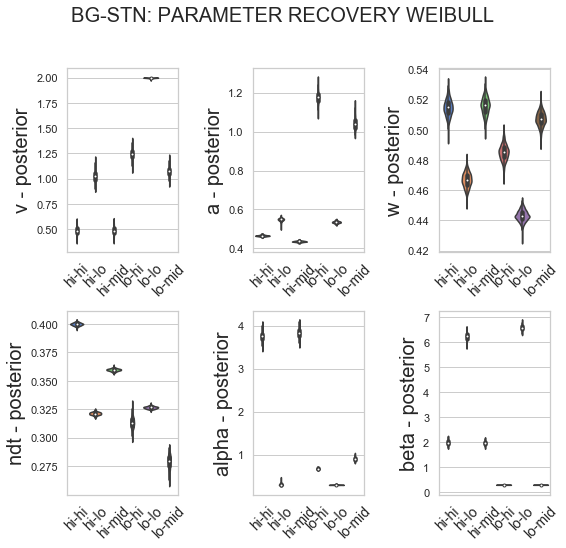

In [101]:
bgn_posterior_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'alpha', 'beta'],
                   title = 'BG-STN: PARAMETER RECOVERY WEIBULL',
                   x_labels = ['hi-hi', 'hi-lo', 'hi-mid', 'lo-hi', 'lo-lo', 'lo-mid'],
                   data = data_weibull_tmp)

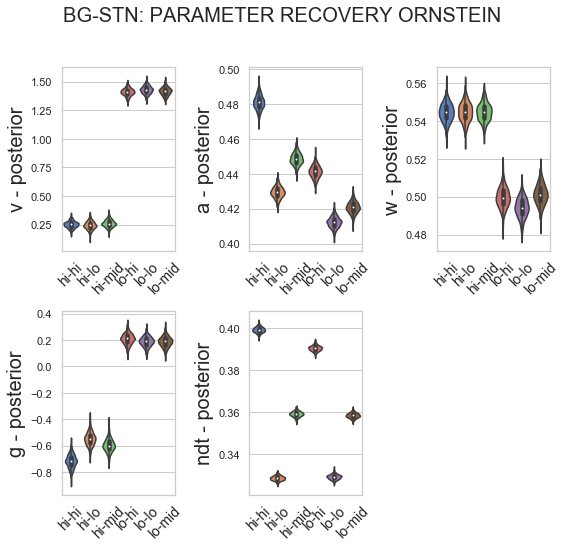

In [100]:
bgn_posterior_plot(ax_titles = ['v', 'a', 'w', 'g', 'ndt'],
                   title = 'BG-STN: PARAMETER RECOVERY ORNSTEIN',
                   x_labels = ['hi-hi', 'hi-lo', 'hi-mid', 'lo-hi', 'lo-lo', 'lo-mid'],
                   data = data_ornstein_tmp)

In [ ]:
# POSTERIOR BOUNDS WEIBULL
for i in range(data_weibull.shape[1]):
    data_weibull_tmp = data_weibull[:, i, :, :]
    bgn_boundary_posterior_plot(ax_titles = ['hiconf_go_stnhi.txt',
                                             'hiconf_go_stnlo.txt',
                                             'hiconf_go_stnmid.txt',
                                             'loconf7_go_stnhi.txt',
                                             'loconf7_go_stnlo.txt',
                                             'loconf7_go_stnmid.txt'], 
                                     title = 'BG-STN: Bound Posterior',
                                     posterior_parameters = data_weibull_tmp,
                                     cols = 3,
                                     model = 'weibull_cdf',
                                     figure_name = 'bg_posterior_bounds_' + str(i) + '_',
                                     n_post_params = 500,
                                     max_t = 2,
                                     show = True)

passed through
passed through


KeyboardInterrupt: 

passed through
passed through
passed through
passed through
passed through
passed through


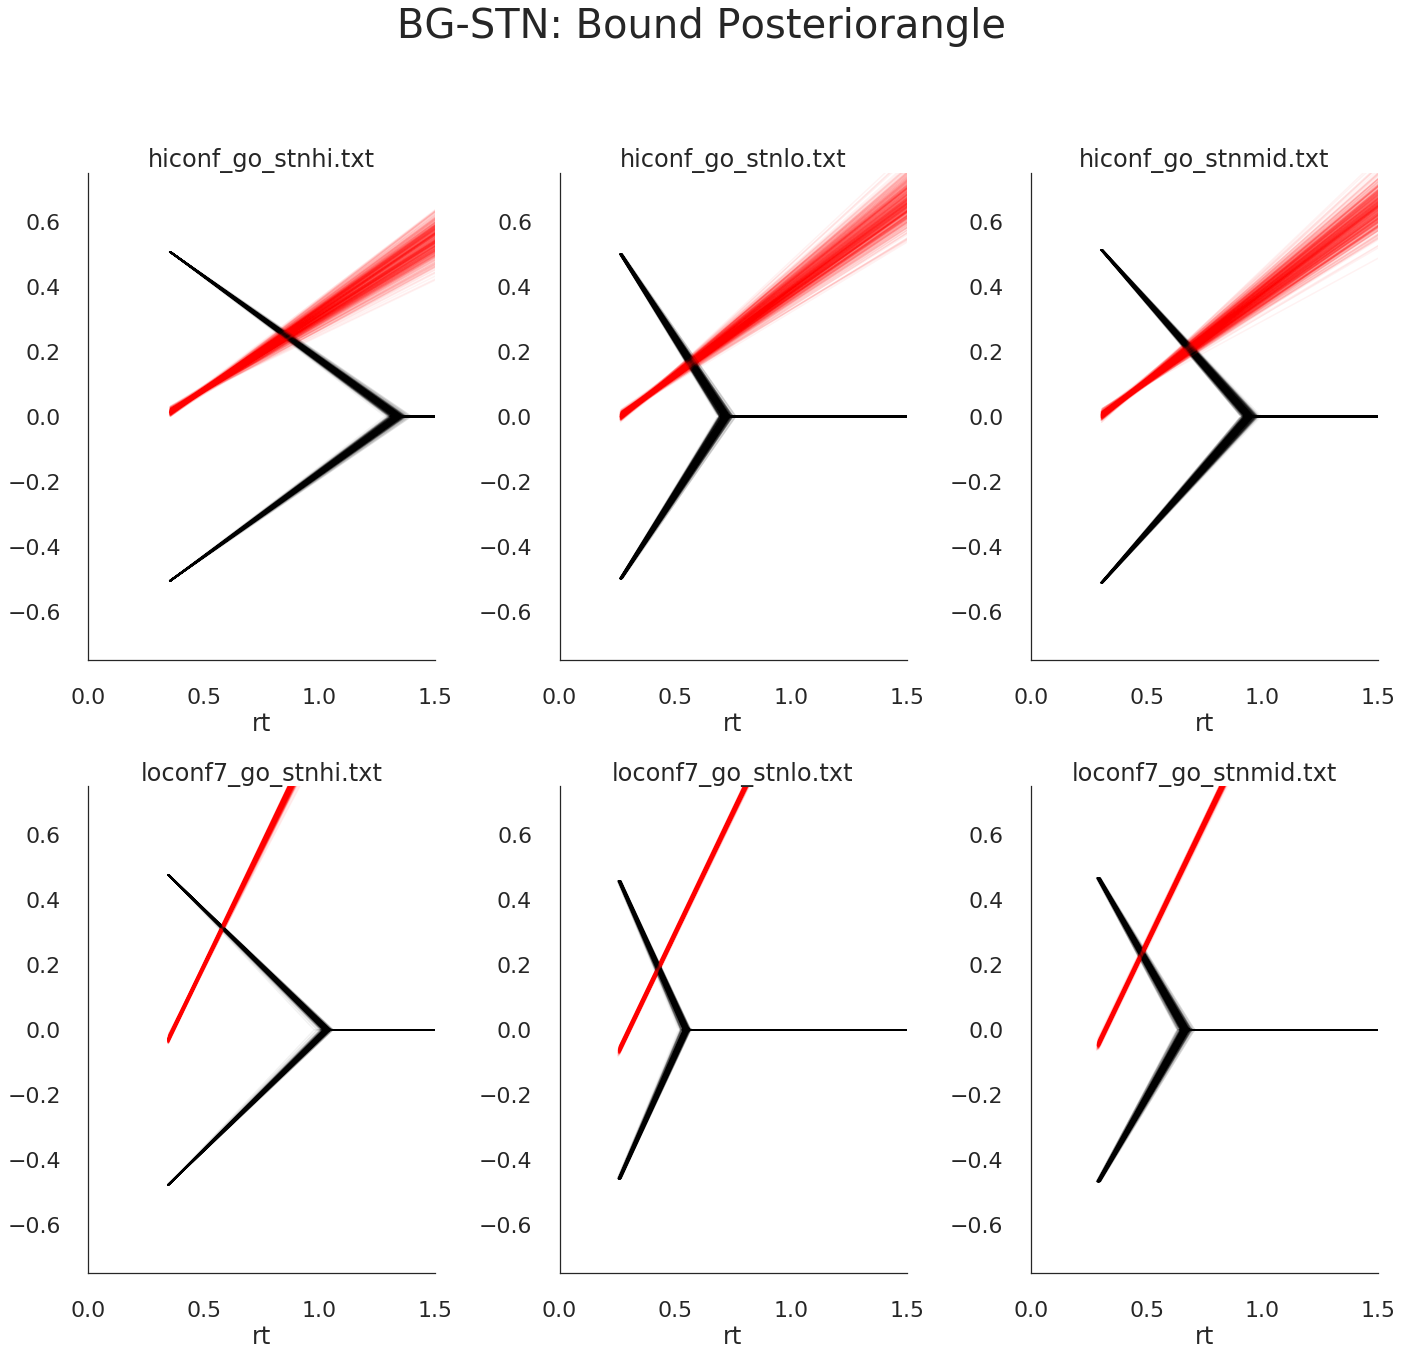

passed through
passed through
passed through
passed through
passed through
passed through


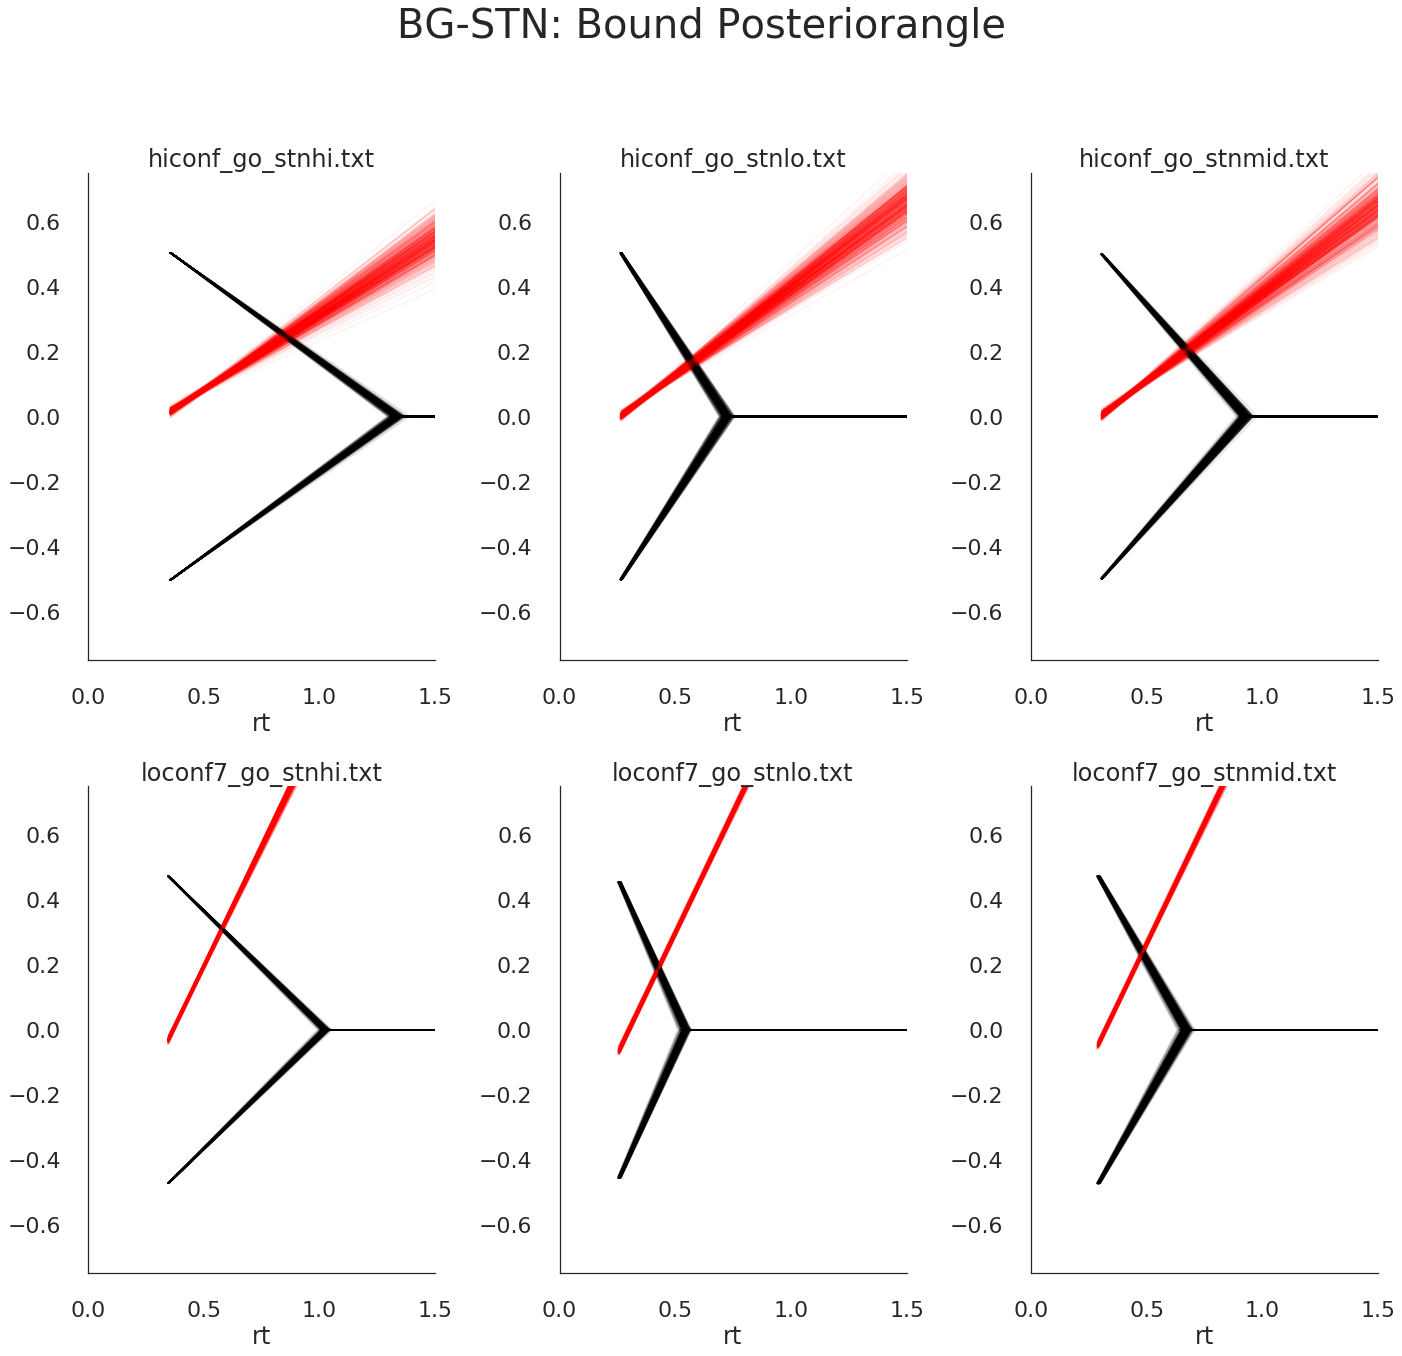

passed through
passed through
passed through
passed through
passed through
passed through


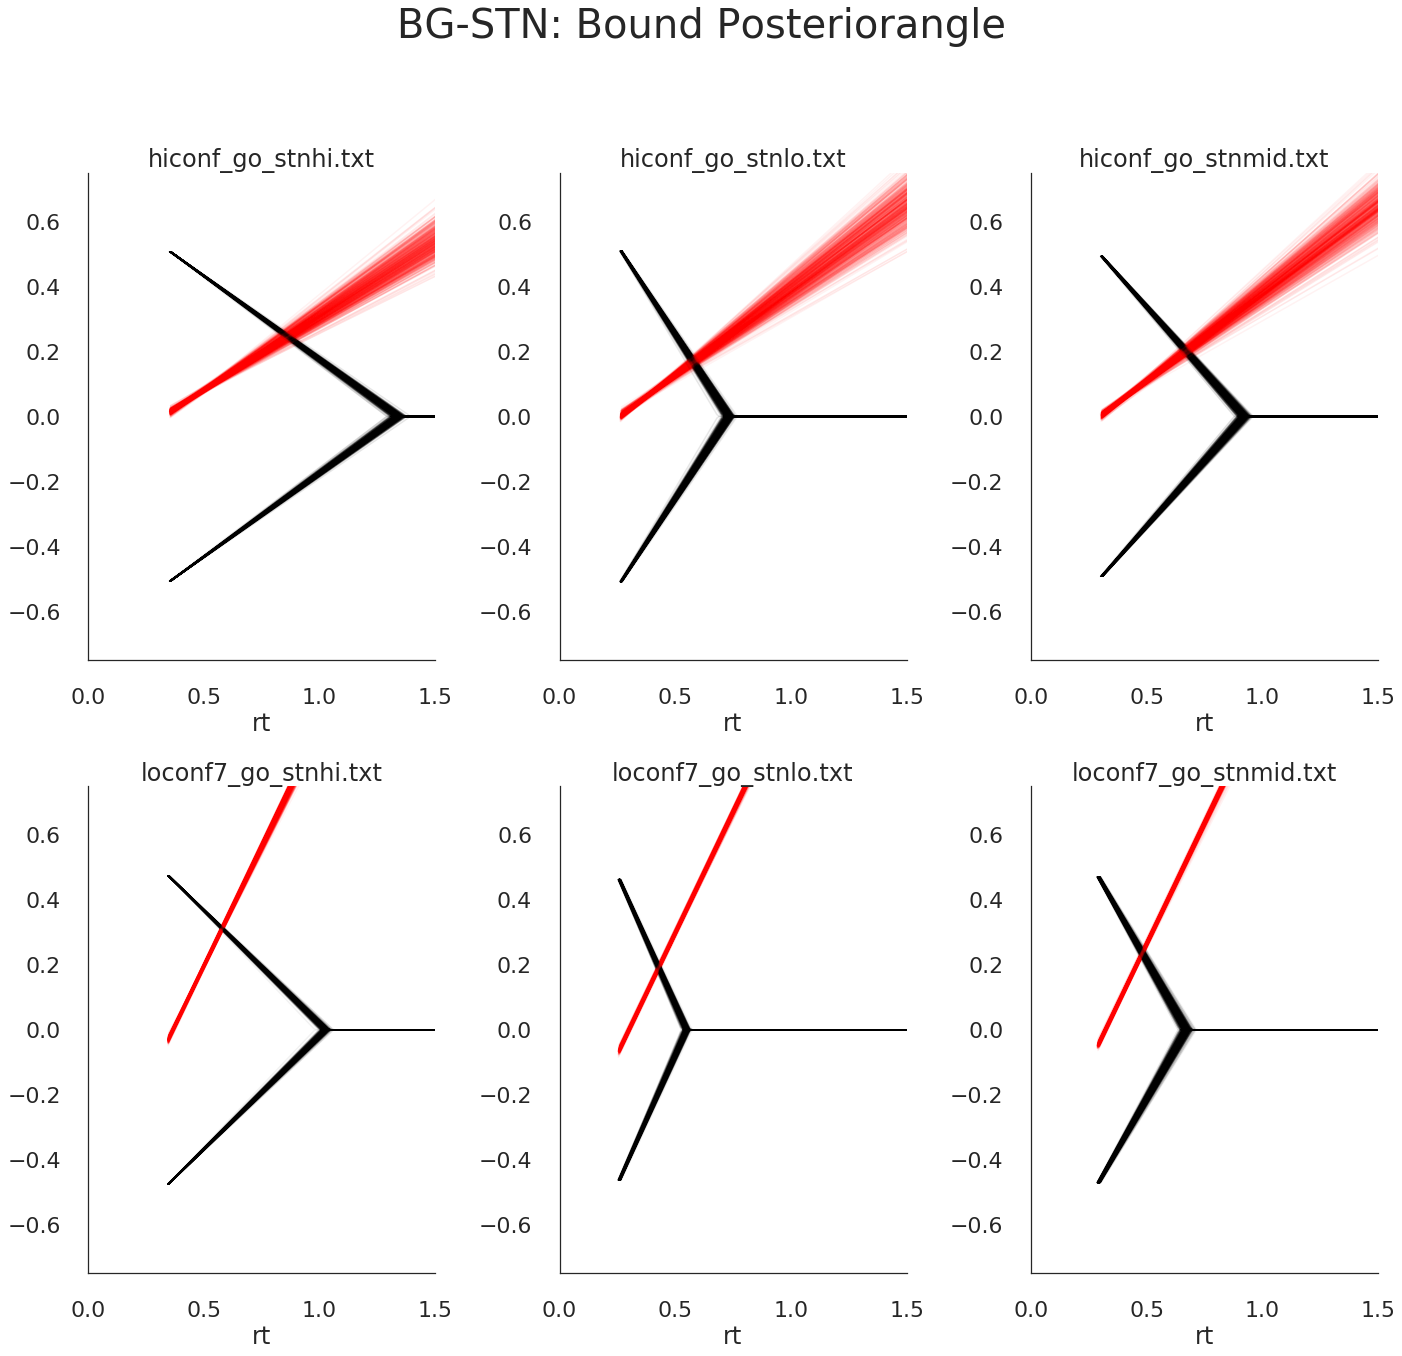

passed through
passed through
passed through
passed through
passed through
passed through


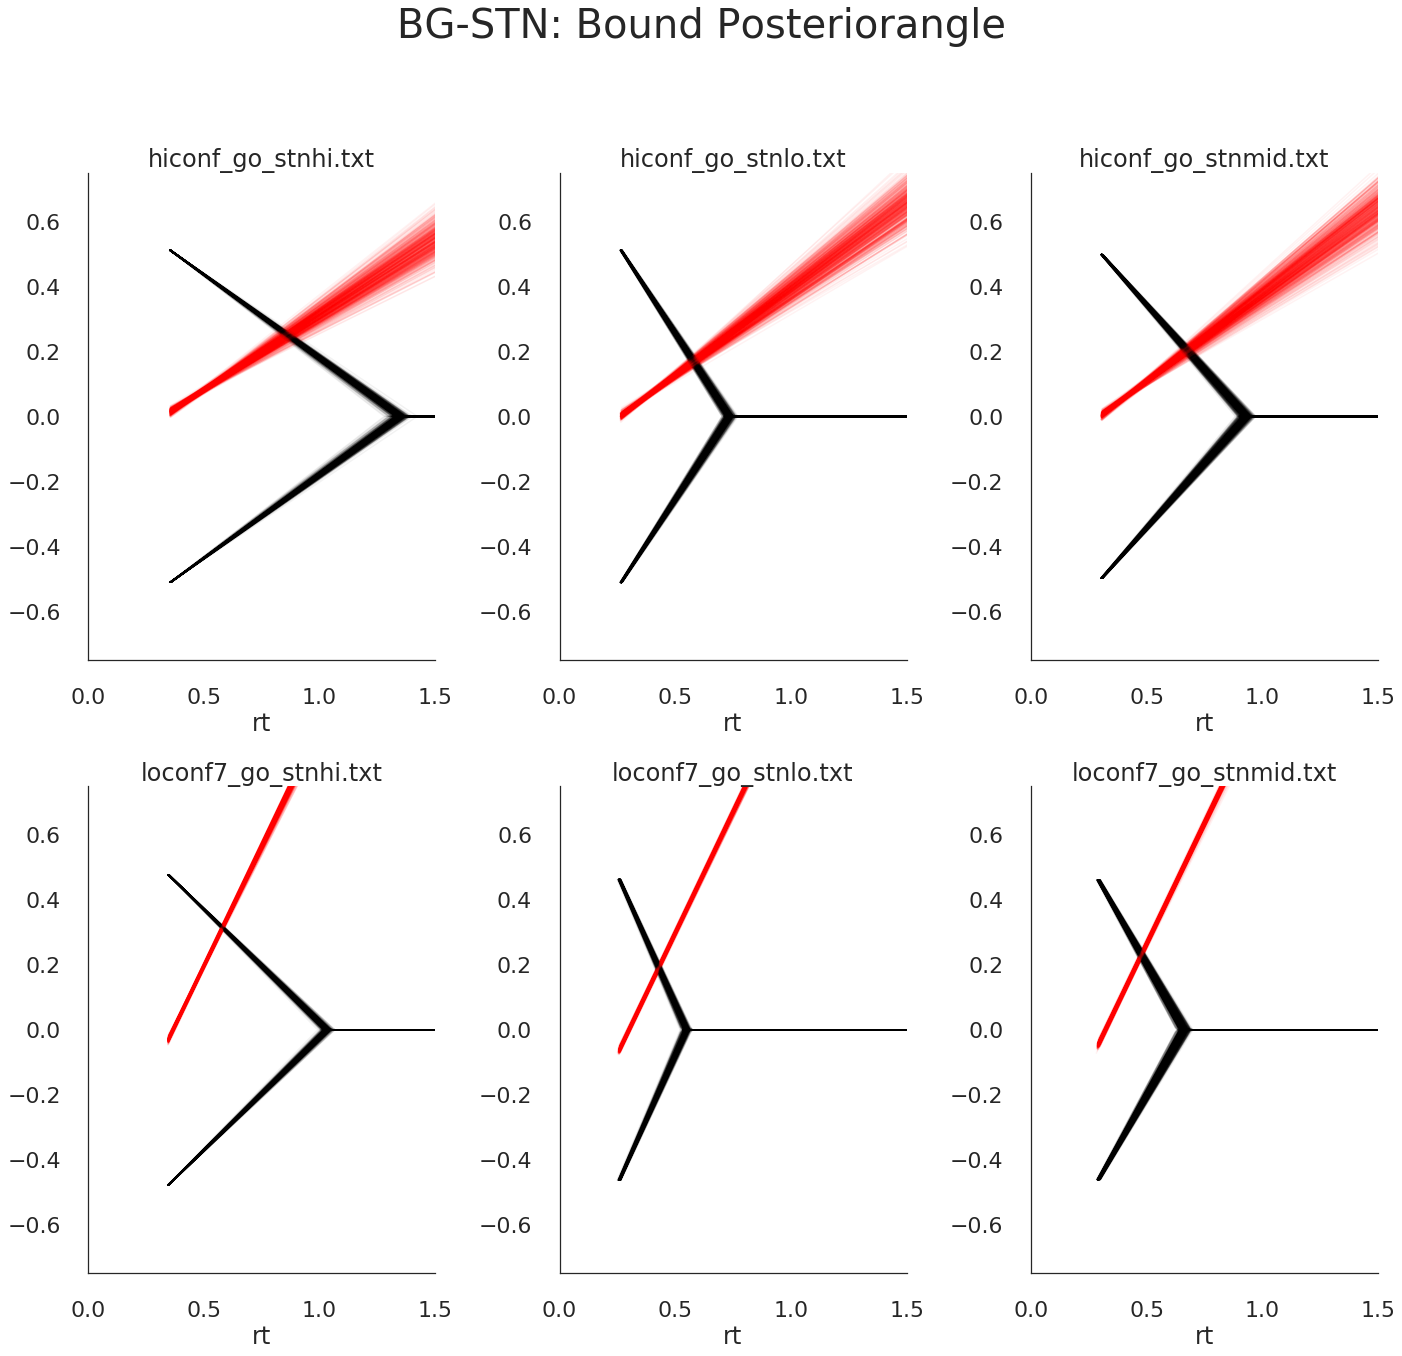

passed through
passed through
passed through
passed through
passed through
passed through


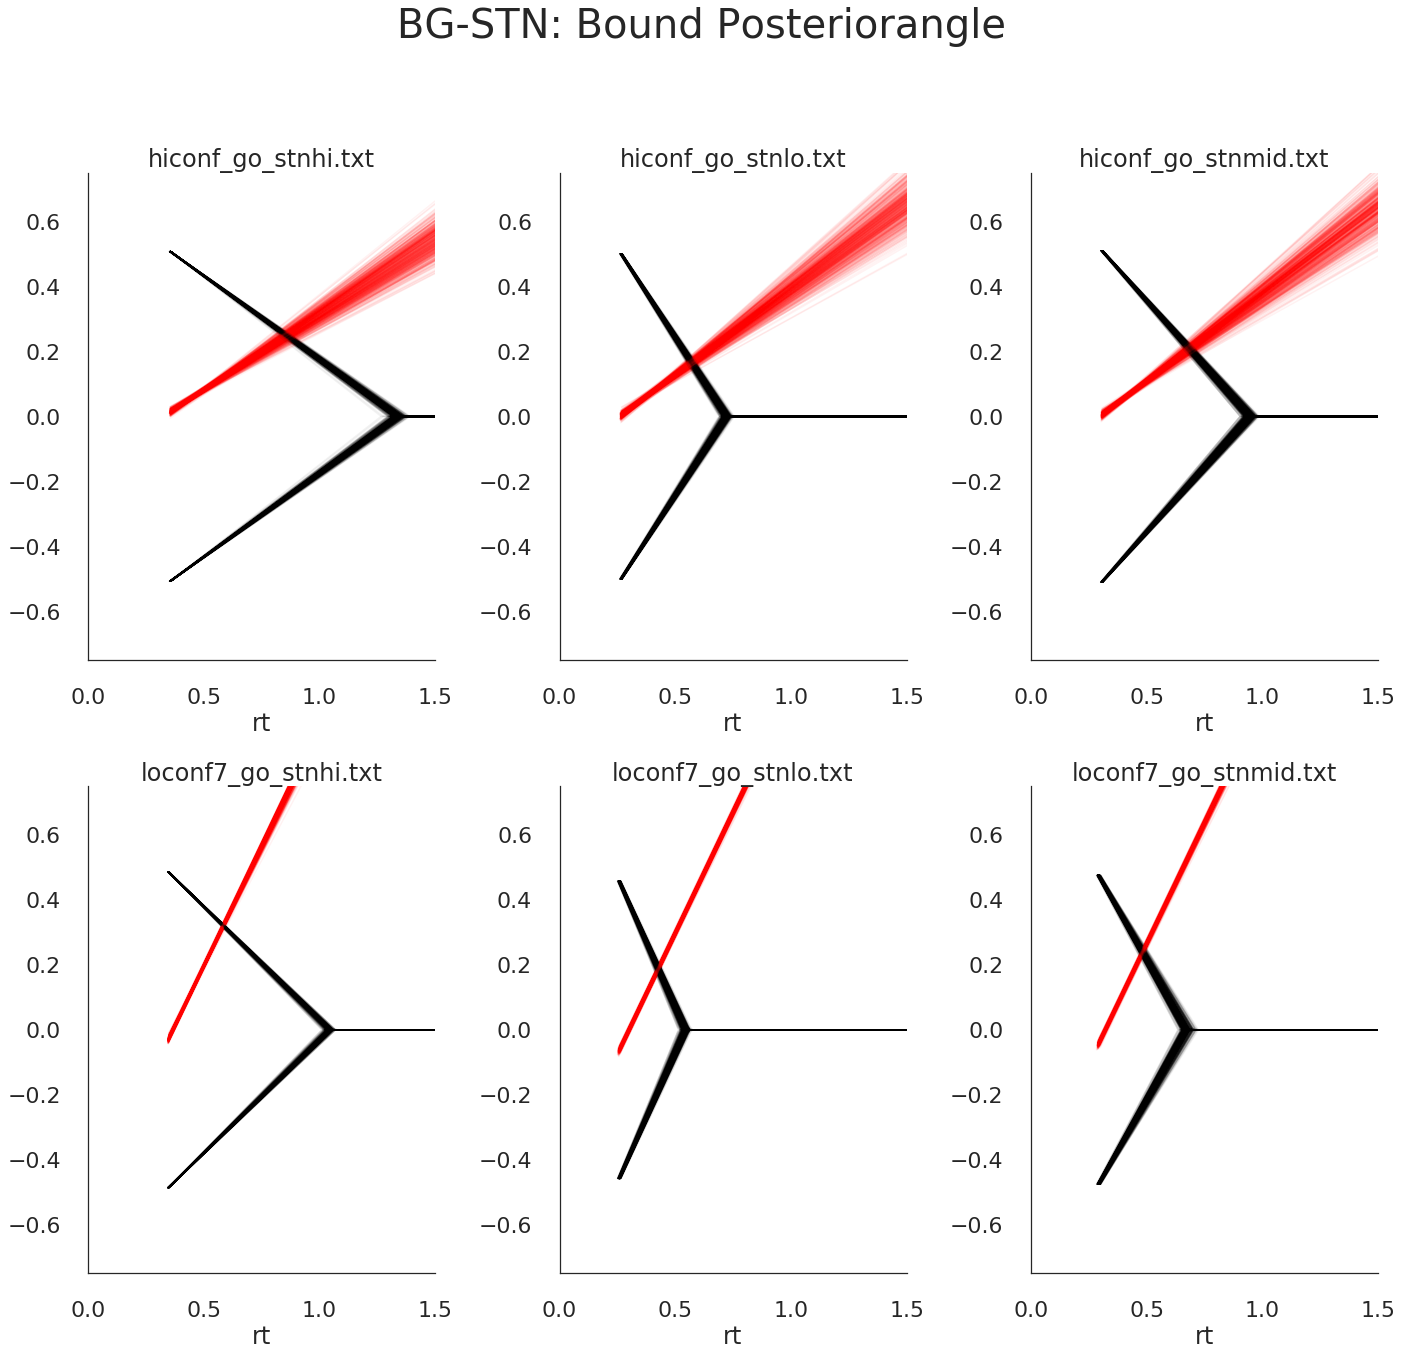

passed through
passed through
passed through
passed through
passed through
passed through


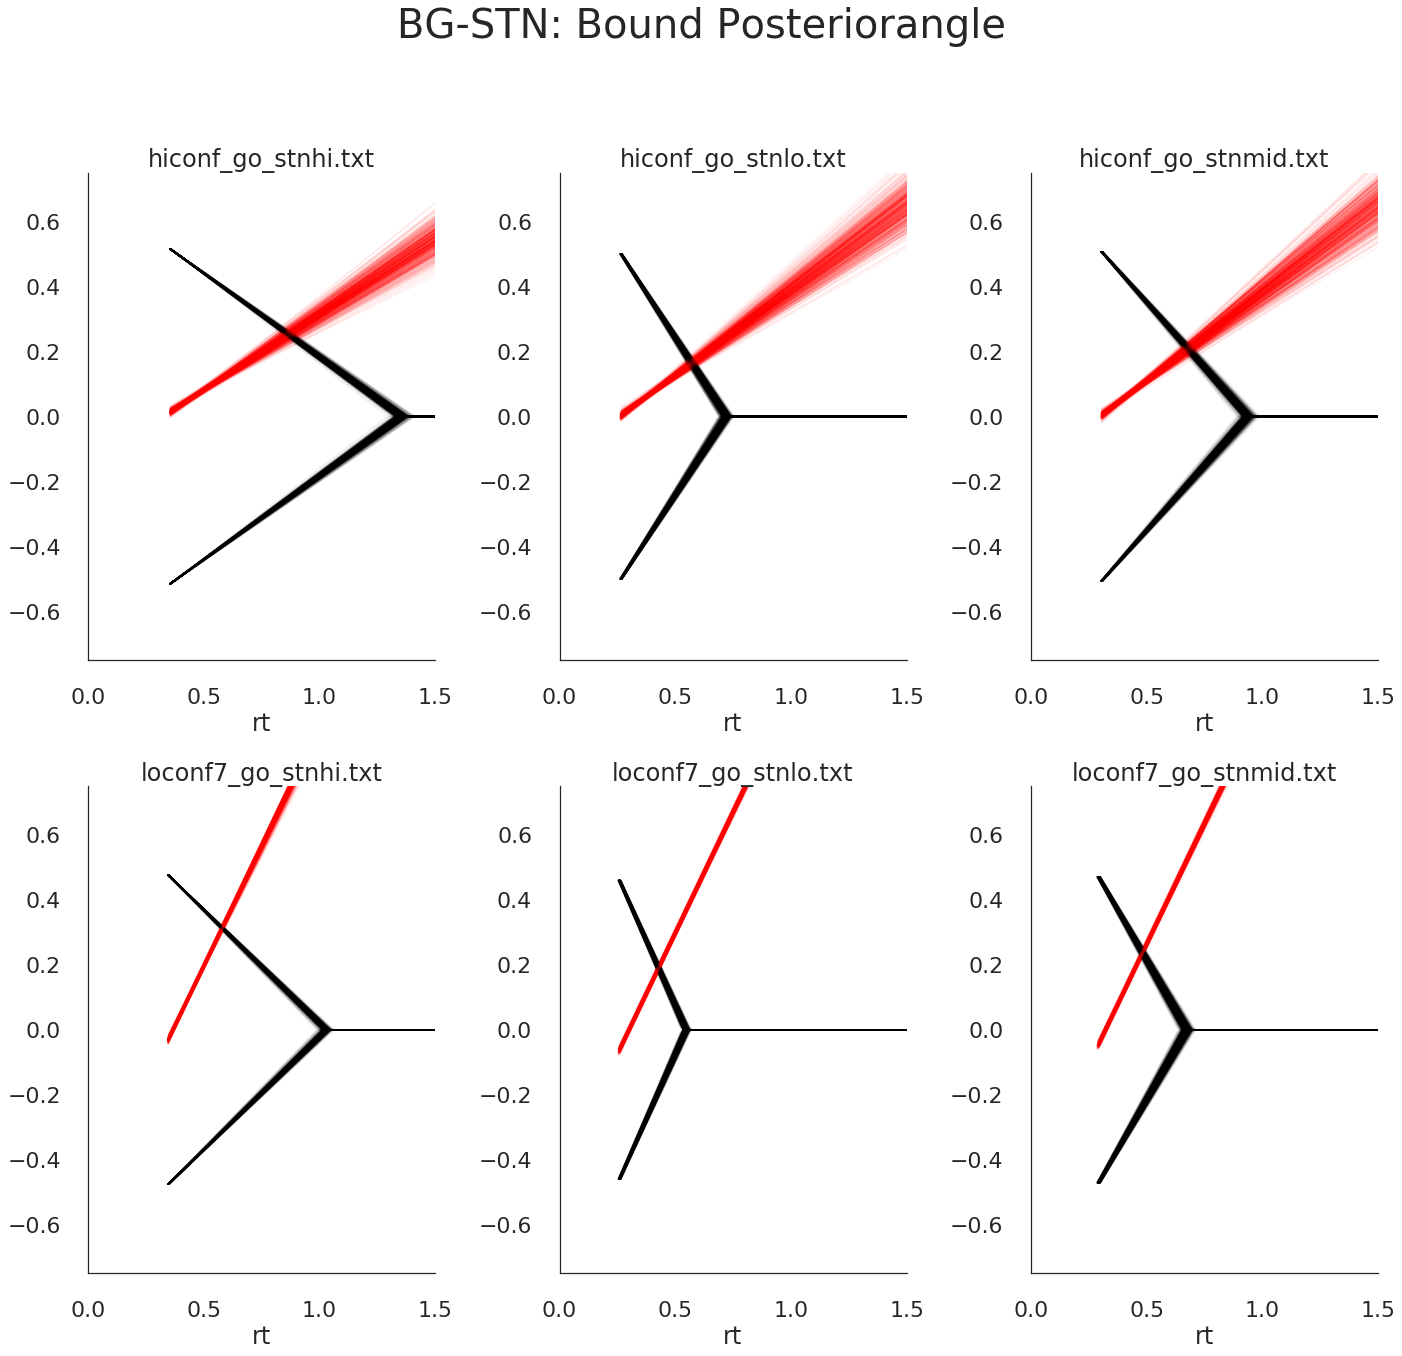

passed through
passed through
passed through
passed through
passed through
passed through


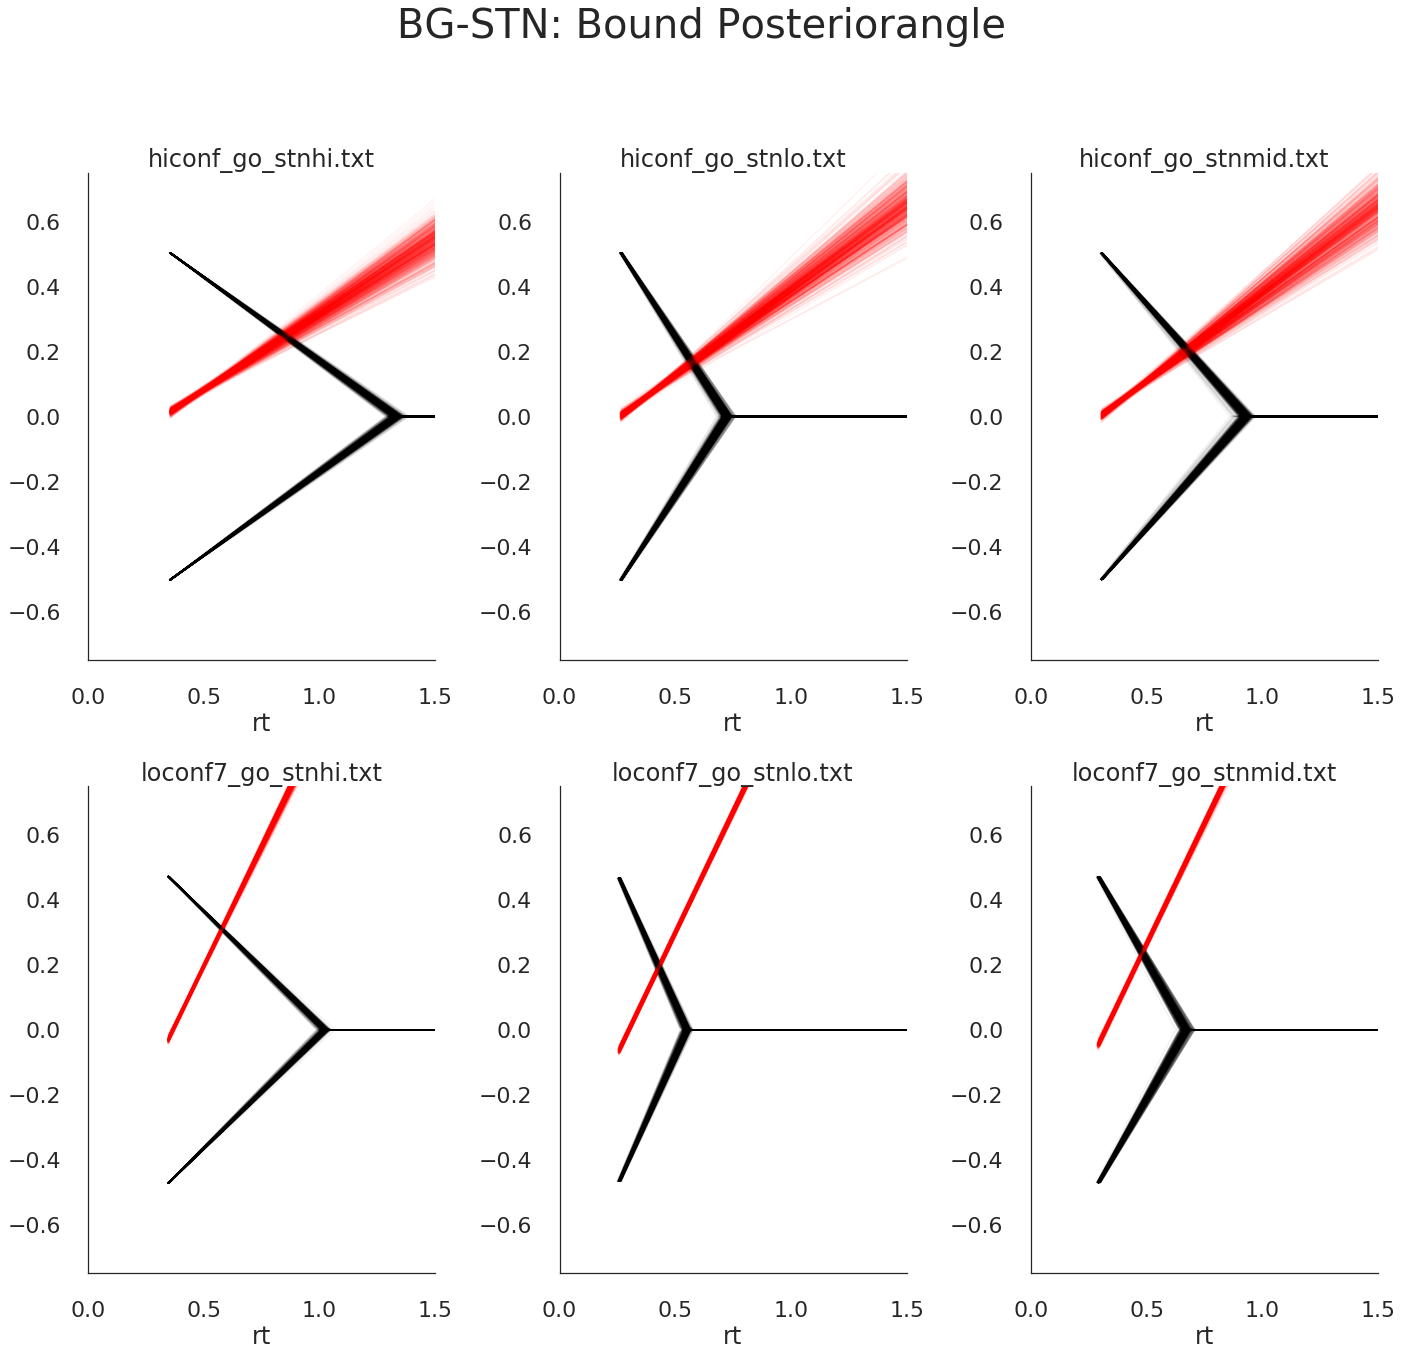

passed through
passed through
passed through
passed through
passed through
passed through


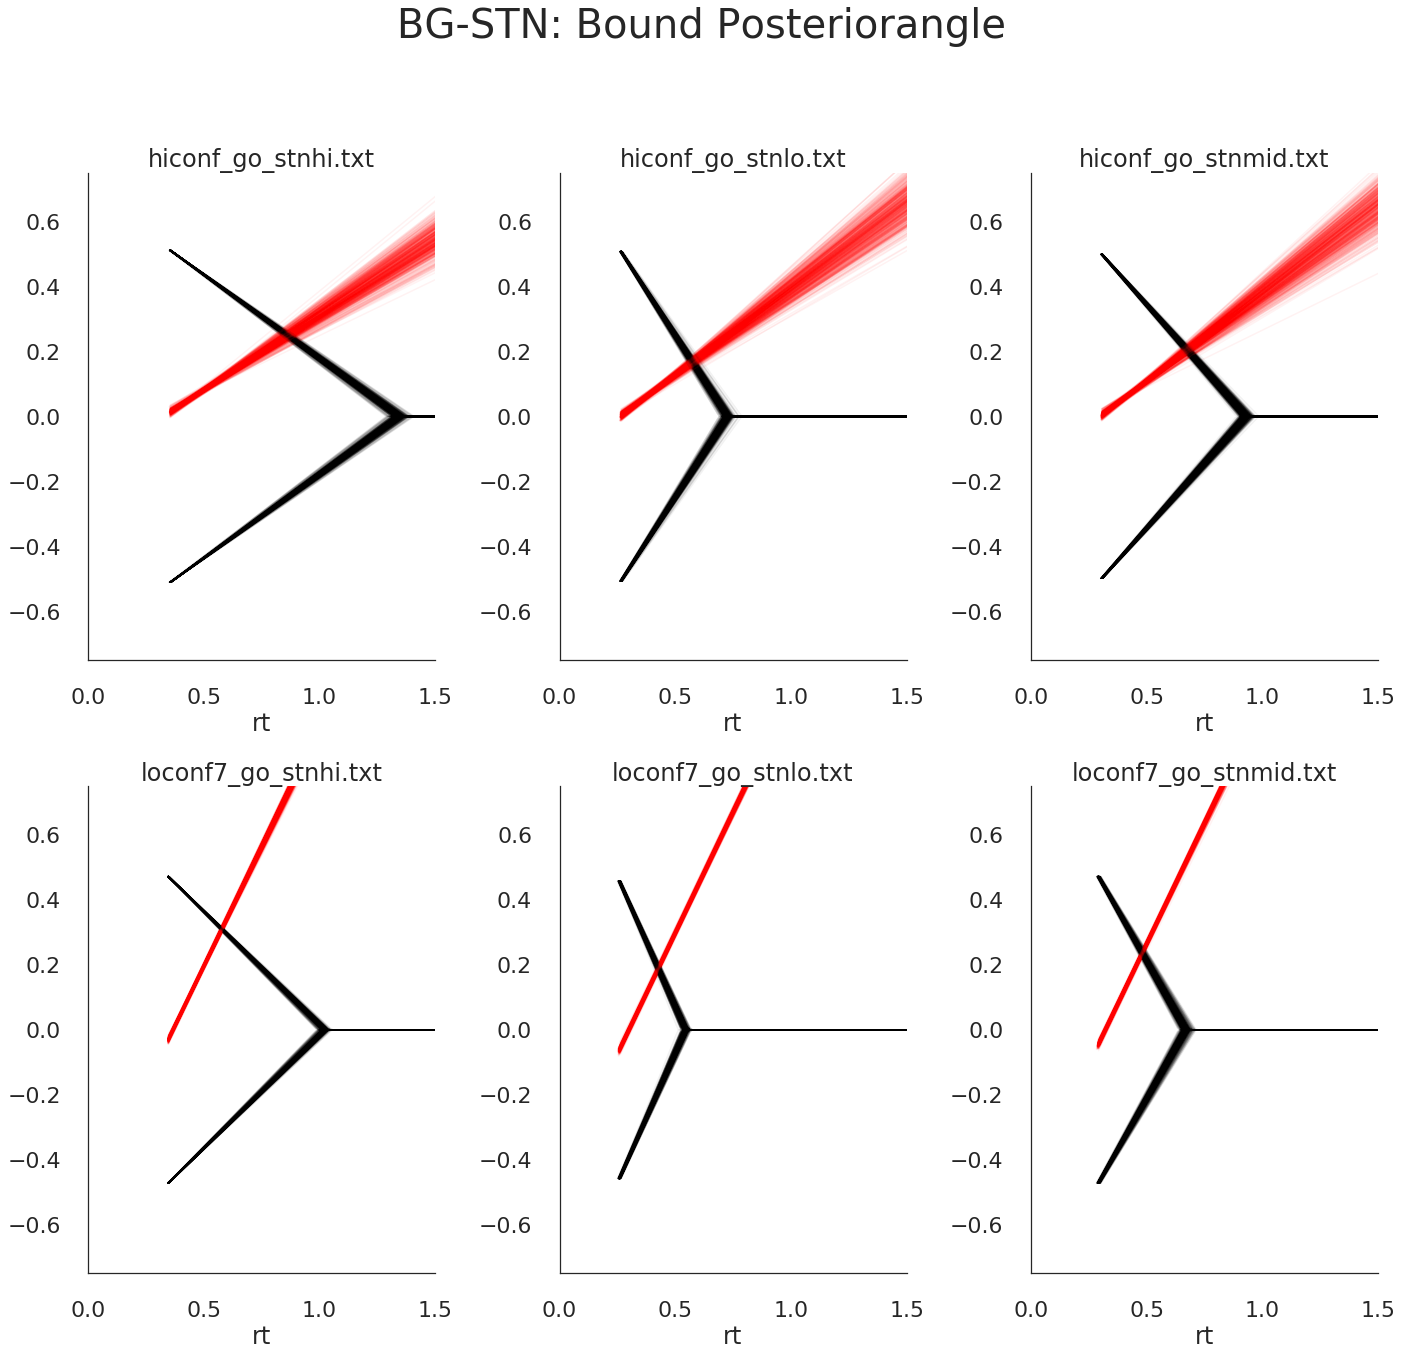

passed through
passed through
passed through
passed through
passed through
passed through


In [ ]:
# POSTERIOR BOUNDS ANGLE
#data_angle_tmp = data_angle[:, 3, :, :]
for i in range(10):
    data_angle_tmp = data_angle[:, i, :, :]
    bgn_boundary_posterior_plot(ax_titles = ['hiconf_go_stnhi.txt',
                                             'hiconf_go_stnlo.txt',
                                             'hiconf_go_stnmid.txt',
                                             'loconf7_go_stnhi.txt',
                                             'loconf7_go_stnlo.txt',
                                             'loconf7_go_stnmid.txt'], 
                                 title = 'BG-STN: Bound Posterior',
                                 posterior_parameters = data_angle_tmp,
                                 cols = 3,
                                 model = 'angle',
                                 figure_name = 'bg_posterior_bounds_' + str(i) + '_',
                                 n_post_params = 500,
                                 max_t = 1.5,
                                 show = True)

In [8]:
data_weibull[5, 3, : ,2]

array([0.6907914 , 0.69258489, 0.68583556, ..., 0.69159711, 0.69145309,
       0.6889138 ])

In [240]:
np.maximum(np.array([1, 1, -1]), 0)

array([1, 1, 0])

In [288]:
data_weibull[1, 0, :, 2]

array([0.57000878, 0.5719913 , 0.57062173, 0.56708743, 0.57389177,
       0.56874276, 0.57683715, 0.57221647, 0.57424908, 0.57443113,
       0.57753502, 0.57659633, 0.57795124, 0.57613759, 0.57496219,
       0.57660572, 0.57020372, 0.57123609, 0.57155467, 0.57506021,
       0.57318069, 0.57194621, 0.57575228, 0.57474043, 0.57485302,
       0.57465701, 0.57480886, 0.57354338, 0.57192428, 0.56663692,
       0.57231865, 0.57006346, 0.56812519, 0.56981654, 0.57051526,
       0.57046603, 0.57083799, 0.57095007, 0.5783019 , 0.57865386,
       0.57852453, 0.57194953, 0.57674804, 0.57134173, 0.57224851,
       0.56985038, 0.57562465, 0.57206439, 0.57032721, 0.57433502,
       0.57092985, 0.57243051, 0.56985505, 0.5692568 , 0.56797362,
       0.56802873, 0.5725918 , 0.57399973, 0.56805856, 0.5688021 ,
       0.56886588, 0.56210472, 0.56793295, 0.56776093, 0.56370525,
       0.56684343, 0.56513182, 0.56958208, 0.56040189, 0.56501378,
       0.56490704, 0.56531474, 0.56505038, 0.56536809, 0.57243

In [14]:
bg_data[0].shape

(6, 5000, 2)